In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
my.col.3<-colorRampPalette(brewer.pal(9,'Set1'))(9)
my.col.3[6] <- '#A6CEE3'
library(qs)
library(data.table)
library(ggthemes)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


qs 0.25.5

Warning message:
“package ‘data.table’ was built under R version 4.2.2”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




#  Fig4C

In [25]:
setwd('/home/mingjian/workbase/04_chemical.methods/07.code_submit/data/Fig4_data/')

In [26]:
count_merge <- readRDS('Fig4C_UMI_count.rds')

In [27]:
head(count_merge)
table(count_merge$sample)

,count,sample,Freq
,<fct>,<fct>,<dbl>
1,0,Ctrl-C4,0.8912830341
2,1,Ctrl-C4,0.0954505276
3,2,Ctrl-C4,0.0113467007
4,3,Ctrl-C4,0.0015846361
5,4,Ctrl-C4,0.0002313106
6,5+,Ctrl-C4,0.0001037910



     Ctrl-C4 Ctrl-Dropseq       IAA-C4  IAA-Dropseq 
           6            6            6            6 

In [28]:
count.col <- c('#16406A','#0658A5','#3984C3','#6FAAD4','#A6CCE7','#D9D9D9')

In [29]:
count_merge$sample <- factor(count_merge$sample,levels = unique(count_merge$sample))

In [31]:
count_merge_label <- merge(count_merge, count_label, by = "sample", all.x = TRUE)%>%mutate(label = ifelse(count == 0,round(label,2),' '))

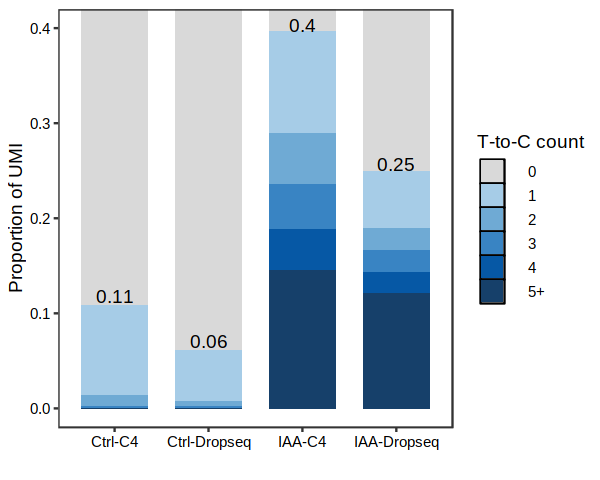

In [32]:
options(repr.plot.width = 5 ,repr.plot.height = 4)
tc_count_p <- ggplot(count_merge_label, aes(fill=count, y=Freq, x=sample)) +
geom_bar(width = 0.7,position="stack", stat="identity") +
ylab("Proportion of UMI") + xlab("") +
   scale_fill_manual(values = rev(count.col))+
#   coord_flip(ylim = c(0,0.4))+
   coord_cartesian(ylim = c(0,0.4))+
   theme_bw()+
   theme(legend.position = "right",panel.grid = element_blank(),
         legend.key =element_rect(colour = "black"),
         legend.spacing.x = unit(0.5, "cm")
        )+
   theme(legend.title  = element_text(colour = 'black'),
         legend.text = element_text(colour = 'black'),
         axis.text = element_text(colour = 'black'))+
    geom_text(aes(label = label), position = position_stack(vjust = 0.01), color = "black") +  
   guides(fill = guide_legend(title = "T-to-C count",title.hjust = 0.5,label.position = "right",keywidth = 1,keyheight = 1,title.position = "top",ncol = 1))
tc_count_p

# Fig4D

In [2]:
rate_c4 <- fread('Fig4_mutation_rate.csv')

In [3]:
head(rate_c4,2)

sample,variable,value
<chr>,<chr>,<dbl>
C4-Ctrl,AC,0.001085648
C4-Ctrl,AC,0.001088578


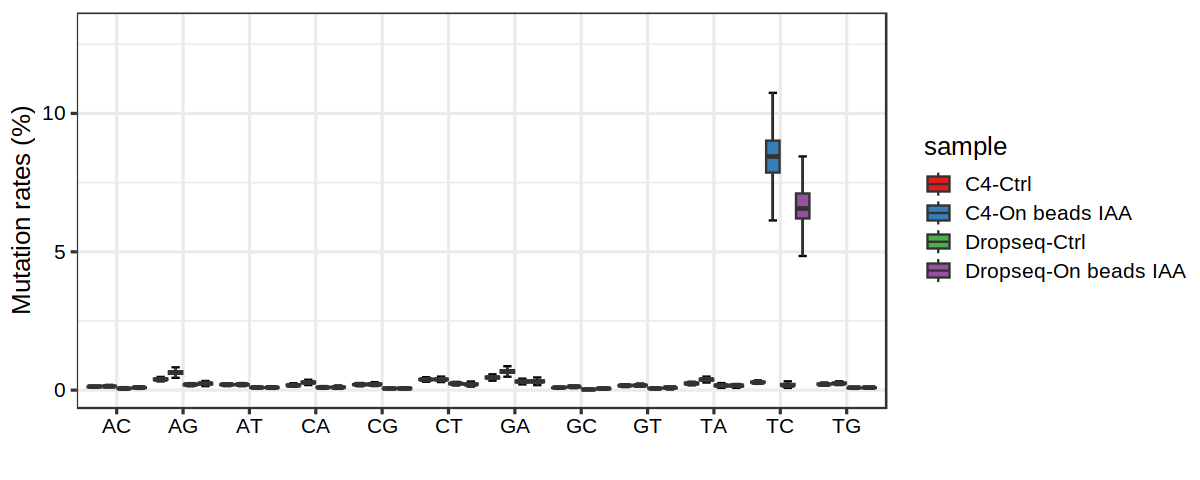

In [4]:
options(repr.plot.height=4,repr.plot.width=10)
ggplot(rate_c4, aes(variable, value*100, fill = sample)) +
  stat_boxplot(geom = "errorbar",width = 0.5,colour='black',position = position_dodge(0.9)) + 
  geom_boxplot(width = 0.9,outlier.shape = NA) +
  ylab("Mutation rates (%)") +
  xlab(" ") +
  scale_fill_manual(values = my.col.3) +
  scale_colour_manual(values = my.col.3)+
  coord_cartesian(ylim = c(0,13))+
  theme_bw(base_size = 15)+
    theme(
        axis.text.x = element_text(colour = 'black'), 
        axis.text.y = element_text(colour = 'black')  
    )

In [5]:
sample_order <-  c('C4-Ctrl','Dropseq-Ctrl','C4-On beads IAA','Dropseq-On beads IAA')

# Fig4E

In [15]:
dat.fig4e <- readRDS('Fig4E_predict.rds')

In [7]:
library(foreach)
library(future.apply)
library(doParallel)
registerDoParallel(cores=10)
plan(multisession, workers = 5)
options(future.globals.maxSize = 2 * 1024^3) 

Warning message:
“package ‘future.apply’ was built under R version 4.2.2”
Loading required package: future

Loading required package: iterators

Loading required package: parallel



In [17]:
predict.nGene <- future_sapply(sample_order, function(u) {
  model1 <- loess(data = dat.fig4e %>%
                    dplyr::filter(sample_plate == u), formula = nGene ~ reads)
  tmp <- predict(model1, 4000)
  return(round(as.numeric(tmp), 0))
})
predict.nGene

C4-Ctrl         Dropseq-Ctrl      C4-On beads IAA 
                1538                 1185                 1605 
Dropseq-On beads IAA 
                1047

In [19]:
library(cowplot)
theme_set(theme_cowplot())
library(ggrastr)

In [18]:
df.extra <- data.frame(reads=rep(4000,4),nGene=predict.nGene)
df.extra$orig.ident <- rownames(df.extra)
df.extra

,reads,nGene,orig.ident
,<dbl>,<dbl>,<chr>
C4-Ctrl,4000,1538,C4-Ctrl
Dropseq-Ctrl,4000,1185,Dropseq-Ctrl
C4-On beads IAA,4000,1605,C4-On beads IAA
Dropseq-On beads IAA,4000,1047,Dropseq-On beads IAA


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


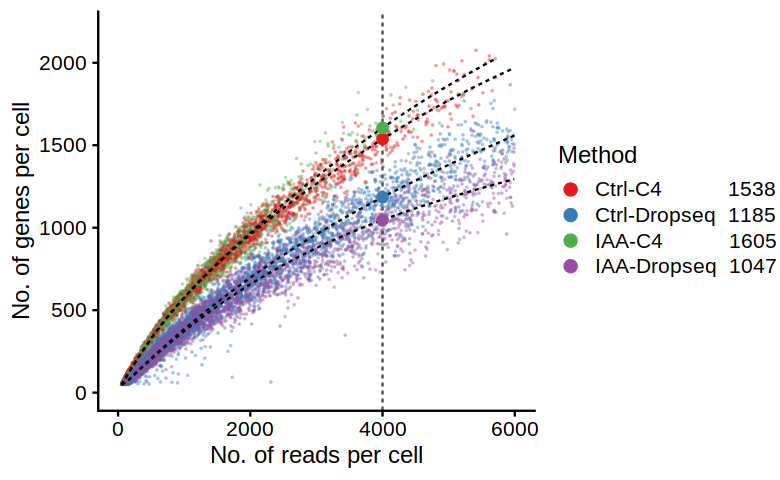

In [20]:
set.seed(123)
options(repr.plot.width=6.5,repr.plot.height=4)
ggplot(data = dat.fig4e,aes(reads,nGene,col=sample_plate)) + 
  geom_point_rast(data=sample_frac(dat.fig4e, 0.3),
             size=.2,shape=19,alpha=.3) + 
  geom_smooth(method="loess",se=F,size=.5,linetype=2,aes(group=sample_plate),col="black") +
  scale_color_manual("Method",values=my.col.3[1:4],labels=c('Ctrl-C4           1538',
                                                      'Ctrl-Dropseq  1185',
                                                      'IAA-C4           1605',
                                                      'IAA-Dropseq  1047')) +
  scale_x_continuous(breaks=seq(0,6000,2000),labels=seq(0,6000,2000)) + 
  coord_cartesian(xlim = c(0,6000),ylim = c(0,2200)) + 
  ylab('No. of genes per cell')+
  xlab('No. of reads per cell')+
  geom_vline(xintercept = 4000,col="grey30",linetype="dashed") +
  geom_point(data = df.extra, col = my.col.3[1:4],size=2.5) + guides(colour = guide_legend(ncol=1,override.aes=list(size=3,alpha=1))) 

# Fig4F

In [21]:
dat.fig4f <- readRDS('Fig4F_predict.rds')

In [22]:
predict.nUMI<- sapply(sample_order,function(u){
    model1 <-  stats::lm(data = dat.fig4f %>% 
                         dplyr::filter(sample_plate == u),formula = nUMI ~ reads)
    tmp <- predict(model1,list(reads=seq(2000,6000,2000)))
    return(round(as.numeric(tmp),0))
})
predict.nUMI

C4-Ctrl,Dropseq-Ctrl,C4-On beads IAA,Dropseq-On beads IAA
1830,1250,1730,1051
3660,2494,3461,2088
5490,3737,5191,3125


In [23]:
df.extra.umi <- data.frame(reads=rep(4000,4),nUMI=predict.nUMI[2,])
df.extra.umi$orig.ident <- rownames(df.extra.umi)
df.extra.umi

,reads,nUMI,orig.ident
,<dbl>,<dbl>,<chr>
C4-Ctrl,4000,3660,C4-Ctrl
Dropseq-Ctrl,4000,2494,Dropseq-Ctrl
C4-On beads IAA,4000,3461,C4-On beads IAA
Dropseq-On beads IAA,4000,2088,Dropseq-On beads IAA


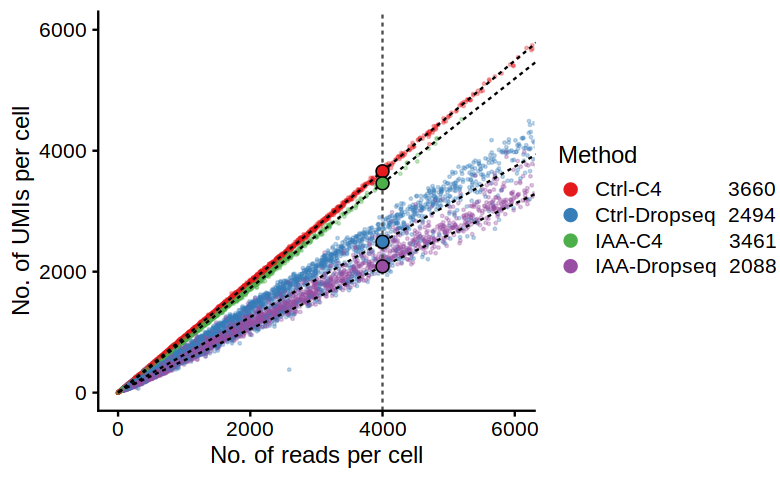

In [24]:
set.seed(123)
options(repr.plot.width=6.5,repr.plot.height=4)
ggplot(dat.fig4f,aes(reads,nUMI,col=sample_plate)) + 
  geom_point_rast(data = sample_frac(dat.fig4f,0.3), size=.5,shape=19,alpha=.3,raster.dpi = getOption("ggrastr.default.dpi", 300)) + 
  geom_smooth(method="lm",formula = y ~ x,se=F,size=.5,linetype=2,aes(group=sample_plate),col="black") +
  scale_color_manual("Method",values=my.col.3[1:4],labels=c('Ctrl-C4           3660',
                                                      'Ctrl-Dropseq  2494',
                                                      'IAA-C4           3461',
                                                      'IAA-Dropseq  2088'
)) +
  scale_x_continuous(breaks=seq(0,6000,2000),labels=seq(0,6000,2000)) + 
  coord_cartesian(xlim = c(0,6000),ylim = c(0,6000)) + 
  geom_vline(xintercept = 4000,col="grey30",linetype="dashed") + 
  geom_point(data = df.extra.umi, fill = my.col.3[1:4],col = 'black',shape = 21,size=3) +
  ylab('No. of UMIs per cell')+
  xlab('No. of reads per cell')+
  guides(colour = guide_legend(ncol=1,override.aes=list(size=3,alpha=1)))

# 